# **🔐 Adversarial Training for Robust Cyber Threat Intelligence NLP Models**

This notebook builds and evaluates text classification models for **Cyber Threat Intelligence (CTI) reports** using DistilBERT.  
The goal is to classify CTI articles into attack techniques and related threat categories, and to study how adversarial training affects model robustness.

We implement and compare:

- Baseline DistilBERT classifier trained on clean CTI data  
- Adversarially trained DistilBERT using FGSM and text perturbation attacks  

We then evaluate:

- Clean (standard) accuracy and macro F1  
- Robust accuracy under adversarial attack  
- Attack Success Rate (ASR)  
- Overall improvement in robustness



**Authors:** Dana Alrijjal, Jouri Aldaghma  
**Course:** NLP Project – Effat University


## Table of Contents

1. [Setup & Imports](#1-setup--imports)
   - [1.1 Install Dependencies](#211-mount-drive--paths)  
   - [1.2 Import Libraries](#212-explore-dataset-folders)  
   - [1.3 Device Configuration](#213-load-raw-cti-labels)   
2. [Data Loading & Preprocessing](#2-data-loading--preprocessing)  
   - [2.1 Mount Drive & Paths](#21-mount-drive--paths)  
   - [2.2 Explore Dataset Folders](#22-explore-dataset-folders)  
   - [2.3 Load Raw CTI Labels](#23-load-raw-cti-labels)  
   - [2.4 Load Raw CTI Text Files](#24-load-raw-cti-text-files)  
   - [2.5 Clean Document Names & Align](#25-clean-document-names--align)  
   - [2.6 Merge Labels with Full Text](#26-merge-labels-with-full-text)  
   - [2.7 Check for Missing Values](#27-check-for-missing-values)  
   - [2.8 Keep Core Columns](#28-reduce-label-space)
   - [2.9 Reduce Label Space](#28-reduce-label-space)  
   - [2.10 Encode Labels](#29-encode-labels)  
   - [2.11 Summary & Inspection](#210-summary--inspection)  
3. [Modeling: Baseline DistilBERT](#3-modeling-baseline-distilbert)  
   - [3.1 CTIDataset Class](#31-ctidataset-class)  
   - [3.2 Label Encoding Sanity Check](#32-label-encoding-sanity-check)  
   - [3.3 Tokenizer & DataLoaders](#33-tokenizer--dataloaders)  
   - [3.4 DistilBERT Model Initialization](#34-distilbert-model-initialization)  
   - [3.5 Evaluation Function](#35-evaluation-function)  
   - [3.6 Training Loop (Baseline)](#36-training-loop-baseline)  
   - [3.7 Baseline Results](#37-baseline-results)  
4. [Adversarial Training](#4-adversarial-training)  
   - [4.1 FGSM Helper Function](#41-fgsm-helper-function)  
   - [4.2 Class Weights for Encoded Labels](#42-class-weights-for-encoded-labels)  
   - [4.3 FGSM Training Function](#43-fgsm-training-function)  
   - [4.4 Adversarial Fine-Tuning Loop](#44-adversarial-fine-tuning-loop)  
   - [4.5 Evaluation After FGSM Training](#45-evaluation-after-fgsm-training)  

5. [Adversarial Evaluation & Analysis](#5-adversarial-evaluation--analysis)  
   - [5.1 Text-level Attack Utilities](#51-text-level-attack-utilities)  
   - [5.2 Single-text Prediction Helper](#52-single-text-prediction-helper)  
   - [5.3 Generate Adversarial Examples](#53-generate-adversarial-examples)  
   - [5.4 Attack Metrics (Accuracy, Robustness, ASR)](#54-attack-metrics-accuracy-robustness-asr)  
   - [5.5 Unified ASR Evaluation Function](#54-attack-metrics-accuracy-robustness-asr)  
   - [5.6 Baseline vs Adversarial Model Comparison](#55-baseline-vs-adversarial-model-comparison)  

6. [Visualization & Reporting](#6-visualization--reporting)  
   - [6.1 Clean Performance: Baseline vs FGSM](#61-clean-performance-baseline-vs-fgsm)  
   - [6.2 Robustness & ASR Comparison](#62-robustness--asr-comparison)  
   - [6.3 Training Label Distribution](#63-training-label-distribution)  
   - [6.4 Confusion Matrix](#64-confusion-matrix)  

7. [Conclusion & Future Work](#7-conclusion--future-work)


## **1. Setup & Imports**

**1.1 Install Dependencies**

In [42]:
!pip install torch transformers textattack openattack scikit-learn pandas numpy matplotlib spacy --quiet

**1.2 Import Libraries**

In [43]:
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
)

from torch.optim import AdamW
import torch

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Adversarial attack frameworks
import textattack

from textattack.attack_recipes import TextFoolerJin2019
from textattack.models.wrappers import HuggingFaceModelWrapper
from textattack.datasets import Dataset

# Utility
from tqdm import tqdm

# spaCy (optional for preprocessing or POS-based attacks)
import spacy

import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Download required NLTK data
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

import random
import os

**1.3 Device Configuration**

In [44]:
# Check CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [45]:
# Verify GPU
torch.cuda.is_available()

True

## **2. Data Loading & Preprocessing**

**2.1 Mount Drive & Set Paths**

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
base = "/content/drive/MyDrive/AnnoCTR"

**2.2 Explore Dataset Structure**

In [48]:
!ls $base
!ls $base/text
!ls $base/linking_mitre_only

all  entities  linking_mitre_only  text
dev  test  train  train_ext
dev.jsonl	       test.jsonl	       train.jsonl
dev_w_con.jsonl        test_w_con.jsonl        train_w_con.jsonl
dev_w_con_w_neg.jsonl  test_w_con_w_neg.jsonl  train_w_con_w_neg.jsonl
dev_w_neg.jsonl        test_w_neg.jsonl        train_w_neg.jsonl


**2.3 Load Raw CTI Labels**

In [49]:
labels_train = pd.read_json(f"{base}/linking_mitre_only/train.jsonl", lines=True)
labels_dev   = pd.read_json(f"{base}/linking_mitre_only/dev.jsonl", lines=True)
labels_test  = pd.read_json(f"{base}/linking_mitre_only/test.jsonl", lines=True)

print(labels_train.shape, labels_dev.shape, labels_test.shape)

(4153, 14) (890, 14) (1918, 14)



**2.4 Load Raw CTI Text Files**

In [50]:
text_dir = f"{base}/all/text"

text_rows = []
for fname in os.listdir(text_dir):
    if fname.endswith(".txt"):
        with open(os.path.join(text_dir, fname), "r", encoding="utf-8") as f:
            content = f.read()
        text_rows.append({
            "document": fname,
            "full_text": content
        })

text_df = pd.DataFrame(text_rows)
print(text_df.shape)
text_df.head()

(399, 2)


,document,full_text
0,zscaler_2020-07-17_new-voicemail-themed-phishi...,New Voicemail-Themed Phishing Attacks Use Evas...
1,lab52_2019-04-02_wirte-group-attacking-the-mid...,WIRTE Group attacking the Middle East\nApril 0...
2,proofpoint_2020-06-22_hakbit-ransomware-campai...,"Hakbit Ransomware Campaign Against Germany, Au..."
3,lab52_2020-01-13_apt27-rootkit-updates.txt,APT27 ZxShell RootKit module updates\nJanuary ...
4,zscaler_2019-03-26_abuse-hidden-well-known-dir...,Abuse of hidden “well-known” directory in HTTP...


**2.5 Clean Document Names & Align**

In [51]:
def clean_name(s):
    return s.replace(".txt", "").strip().lower()

# Clean both datasets
text_df["doc_clean"] = text_df["document"].apply(clean_name)
labels_train["doc_clean"] = labels_train["document"].apply(clean_name)
labels_dev["doc_clean"]   = labels_dev["document"].apply(clean_name)
labels_test["doc_clean"]  = labels_test["document"].apply(clean_name)

# Create set of available text filenames
available_clean = set(text_df["doc_clean"])

# Filter labels to only keep rows that exist in text_df
labels_train_filtered = labels_train[labels_train["doc_clean"].isin(available_clean)]
labels_dev_filtered   = labels_dev[labels_dev["doc_clean"].isin(available_clean)]
labels_test_filtered  = labels_test[labels_test["doc_clean"].isin(available_clean)]

print("Train matches:", labels_train_filtered.shape)
print("Dev matches:",   labels_dev_filtered.shape)
print("Test matches:",  labels_test_filtered.shape)

Train matches: (4153, 15)
Dev matches: (782, 15)
Test matches: (1918, 15)


**2.6 Merge Labels with Full Text**

In [52]:
final_train = labels_train_filtered.merge(
    text_df[["doc_clean", "full_text"]],
    on="doc_clean",
    how="left"
)

final_dev = labels_dev_filtered.merge(
    text_df[["doc_clean", "full_text"]],
    on="doc_clean",
    how="left"
)

final_test = labels_test_filtered.merge(
    text_df[["doc_clean", "full_text"]],
    on="doc_clean",
    how="left"
)


**2.7 Check for Missing Text Matches**

In [53]:
print("Missing full_text in train:", final_train["full_text"].isna().sum())
print("Missing full_text in dev:", final_dev["full_text"].isna().sum())
print("Missing full_text in test:", final_test["full_text"].isna().sum())

Missing full_text in train: 0
Missing full_text in dev: 0
Missing full_text in test: 0


**2.8 Keep Core Columns**

In [54]:
final_train = final_train[[
    "document",
    "full_text",
    "label",
    "label_title",
    "entity_type",
    "label_id"
]]

final_dev = final_dev[[
    "document",
    "full_text",
    "label",
    "label_title",
    "entity_type",
    "label_id"
]]

final_test = final_test[[
    "document",
    "full_text",
    "label",
    "label_title",
    "entity_type",
    "label_id"
]]


**2.9 Reduce Label Space (Top K or N Threshold)**

In [55]:
# Count frequencies from TRAIN only
label_counts = final_train["label_id"].value_counts()
print("Train label counts (top 20):")
print(label_counts.head(20))

# Keep only top 15 most frequent classes
top_k = 15
freq_labels = label_counts.nlargest(top_k).index.tolist()
print(f"\nKept top {top_k} classes:", freq_labels)

# Map rare labels → OTHER
def remap_label(lbl):
    return str(lbl) if lbl in freq_labels else "OTHER"

final_train["label_mapped"] = final_train["label_id"].apply(remap_label)
final_dev["label_mapped"]   = final_dev["label_id"].apply(remap_label)
final_test["label_mapped"]  = final_test["label_id"].apply(remap_label)

print("\nTrain mapped label counts:")
print(final_train["label_mapped"].value_counts())
print("\nDev mapped label counts:")
print(final_dev["label_mapped"].value_counts())
print("\nTest mapped label counts:")
print(final_test["label_mapped"].value_counts())

Train label counts (top 20):
label_id
581     407
161     273
368     206
467     168
202     117
1049     84
1348     79
688      76
452      75
544      65
514      64
685      61
1170     55
1401     47
195      46
1153     46
376      44
8        44
1308     43
142      40
Name: count, dtype: int64

Kept top 15 classes: [581, 161, 368, 467, 202, 1049, 1348, 688, 452, 544, 514, 685, 1170, 1401, 195]

Train mapped label counts:
label_mapped
OTHER    2330
581       407
161       273
368       206
467       168
202       117
1049       84
1348       79
688        76
452        75
544        65
514        64
685        61
1170       55
1401       47
195        46
Name: count, dtype: int64

Dev mapped label counts:
label_mapped
OTHER    515
368       61
467       56
161       45
581       42
202       24
514       13
544       10
1049       8
452        4
195        3
1170       1
Name: count, dtype: int64

Test mapped label counts:
label_mapped
OTHER    1211
161       136
467       135


**2.10 Encode Labels**

In [56]:
all_labels = pd.concat(
    [final_train["label_mapped"],
     final_dev["label_mapped"],
     final_test["label_mapped"]]
).unique()

label2id = {label: idx for idx, label in enumerate(sorted(all_labels))}
id2label = {idx: label for label, idx in label2id.items()}

print("\nTotal unique labels AFTER reduction:", len(label2id))
print(label2id)

# Encode mapped labels
final_train["label_id_encoded"] = final_train["label_mapped"].map(label2id)
final_dev["label_id_encoded"]   = final_dev["label_mapped"].map(label2id)
final_test["label_id_encoded"]  = final_test["label_mapped"].map(label2id)

# Check NaNs, then drop only those rows
print("\nNaNs in encoded labels (train/dev/test):",
      final_train["label_id_encoded"].isna().sum(),
      final_dev["label_id_encoded"].isna().sum(),
      final_test["label_id_encoded"].isna().sum())

final_train = final_train.dropna(subset=["label_id_encoded"]).reset_index(drop=True)
final_dev   = final_dev.dropna(subset=["label_id_encoded"]).reset_index(drop=True)
final_test  = final_test.dropna(subset=["label_id_encoded"]).reset_index(drop=True)

final_train["label_id_encoded"] = final_train["label_id_encoded"].astype(int)
final_dev["label_id_encoded"]   = final_dev["label_id_encoded"].astype(int)
final_test["label_id_encoded"]  = final_test["label_id_encoded"].astype(int)

print("\nUnique dev labels:", final_dev["label_id_encoded"].nunique())
print("Unique test labels:", final_test["label_id_encoded"].nunique())
print("Dev encoded label counts (head):")
print(final_dev["label_id_encoded"].value_counts().head())
print("Test encoded label counts (head):")
print(final_test["label_id_encoded"].value_counts().head())


Total unique labels AFTER reduction: 16
{'1049': 0, '1170': 1, '1348': 2, '1401': 3, '161': 4, '195': 5, '202': 6, '368': 7, '452': 8, '467': 9, '514': 10, '544': 11, '581': 12, '685': 13, '688': 14, 'OTHER': 15}

NaNs in encoded labels (train/dev/test): 0 0 0

Unique dev labels: 12
Unique test labels: 13
Dev encoded label counts (head):
label_id_encoded
15    515
7      61
9      56
4      45
12     42
Name: count, dtype: int64
Test encoded label counts (head):
label_id_encoded
15    1211
4      136
9      135
7      126
12     113
Name: count, dtype: int64


In [57]:
print("=" * 60)
print("BEFORE BALANCING:")
print("=" * 60)
print(f"Total training samples: {len(final_train)}")
print(f"OTHER samples: {(final_train['label_mapped']=='OTHER').sum()}")
print(f"OTHER percentage: {(final_train['label_mapped']=='OTHER').sum() / len(final_train) * 100:.1f}%")
print("\nLabel distribution:")
print(final_train["label_mapped"].value_counts().head(10))

# Separate OTHER and non-OTHER samples
other_samples = final_train[final_train['label_mapped'] == 'OTHER']
non_other_samples = final_train[final_train['label_mapped'] != 'OTHER']

# Keep only 600 OTHER samples (instead of 1296)
# This makes OTHER ~17% instead of 31%
keep_other = other_samples.sample(n=600, random_state=42)

# Combine back together
final_train_balanced = pd.concat([non_other_samples, keep_other])
final_train_balanced = final_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n" + "=" * 60)
print("AFTER BALANCING:")
print("=" * 60)
print(f"Total training samples: {len(final_train_balanced)}")
print(f"OTHER samples: {(final_train_balanced['label_mapped']=='OTHER').sum()}")
print(f"OTHER percentage: {(final_train_balanced['label_mapped']=='OTHER').sum() / len(final_train_balanced) * 100:.1f}%")
print("\nLabel distribution:")
print(final_train_balanced["label_mapped"].value_counts().head(10))

# Replace the original final_train with balanced version
final_train = final_train_balanced.copy()

print("\n Dataset balanced successfully!")

BEFORE BALANCING:
Total training samples: 4153
OTHER samples: 2330
OTHER percentage: 56.1%

Label distribution:
label_mapped
OTHER    2330
581       407
161       273
368       206
467       168
202       117
1049       84
1348       79
688        76
452        75
Name: count, dtype: int64

AFTER BALANCING:
Total training samples: 2423
OTHER samples: 600
OTHER percentage: 24.8%

Label distribution:
label_mapped
OTHER    600
581      407
161      273
368      206
467      168
202      117
1049      84
1348      79
688       76
452       75
Name: count, dtype: int64

 Dataset balanced successfully!


**2.12 Summary & Quick Inspection**

In [58]:
print("Final training dataset size:", final_train.shape)
print("Final dev dataset size:", final_dev.shape)
print("Final test dataset size:", final_test.shape)

print("\nTrain mapped label distribution (TOP 10):")
print(final_train["label_mapped"].value_counts().head(10))

print("\n Data preprocessing complete!")
print(f"Using {len(final_train)} training samples")
print(f"Using {len(final_dev)} validation samples")
print(f"Using {len(final_test)} test samples")

Final training dataset size: (2423, 8)
Final dev dataset size: (782, 8)
Final test dataset size: (1918, 8)

Train mapped label distribution (TOP 10):
label_mapped
OTHER    600
581      407
161      273
368      206
467      168
202      117
1049      84
1348      79
688       76
452       75
Name: count, dtype: int64

 Data preprocessing complete!
Using 2423 training samples
Using 782 validation samples
Using 1918 test samples


## ***3. Train Baseline Model***

**3.1 Create Dataset Class**

In [59]:
class CTIDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

**3.2 Label Encoding Sanity Check**

In [60]:
print("Train:", final_train.shape)
print("Dev:", final_dev.shape)
print("Test:", final_test.shape)

print("Train labels (encoded):", final_train["label_id_encoded"].nunique())
print("Dev labels (encoded):",   final_dev["label_id_encoded"].nunique())
print("Test labels (encoded):",  final_test["label_id_encoded"].nunique())

print(
    "Train ID range (encoded):",
    final_train["label_id_encoded"].min(), "→", final_train["label_id_encoded"].max()
)
print(
    "Dev ID range (encoded):",
    final_dev["label_id_encoded"].min(), "→", final_dev["label_id_encoded"].max()
)
print(
    "Test ID range (encoded):",
    final_test["label_id_encoded"].min(), "→", final_test["label_id_encoded"].max()
)

Train: (2423, 8)
Dev: (782, 8)
Test: (1918, 8)
Train labels (encoded): 16
Dev labels (encoded): 12
Test labels (encoded): 13
Train ID range (encoded): 0 → 15
Dev ID range (encoded): 0 → 15
Test ID range (encoded): 0 → 15


**3.3 Tokenizer & DataLoaders**

In [61]:
tokenizer = AutoTokenizer.from_pretrained("jackaduma/SecBERT")

train_dataset = CTIDataset(
    final_train["full_text"].tolist(),
    final_train["label_id_encoded"].tolist(),  # encoded labels
    tokenizer,
    max_len=512
)

dev_dataset = CTIDataset(
    final_dev["full_text"].tolist(),
    final_dev["label_id_encoded"].tolist(),
    tokenizer,
    max_len=512
)

test_dataset = CTIDataset(
    final_test["full_text"].tolist(),
    final_test["label_id_encoded"].tolist(),
    tokenizer,
    max_len=512
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_loader   = DataLoader(dev_dataset, batch_size=8)
test_loader  = DataLoader(test_dataset, batch_size=8)

**3.4 Initialize DistilBERT Classifier**

In [62]:
model = AutoModelForSequenceClassification.from_pretrained(
    "jackaduma/SecBERT",
    num_labels=len(label2id),
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model num_labels:", model.num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at jackaduma/SecBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model num_labels: 16


**3.5 Evaluation Function**

In [63]:
def evaluate(model, loader):
    model.eval()
    preds, true_labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            preds.extend(predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average="macro")
    return acc, f1

**3.6 Training Loop (Baseline)**

In [64]:
# Training parameters
epochs = 5
optimizer = AdamW(model.parameters(), lr=2e-5)  # slightly lower LR

# Add scheduler
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=total_steps
)

# Early stopping
best_f1 = 0
patience = 3
patience_counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        outputs = model(
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device),
            labels=batch["labels"].to(device),
        )

        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()  # ADD THIS

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

    dev_acc, dev_f1 = evaluate(model, dev_loader)
    print(f"DEV - Acc: {dev_acc:.4f}, F1: {dev_f1:.4f}")

100%|██████████| 303/303 [02:33<00:00,  1.97it/s]


Epoch 1 Loss: 2.0708
DEV - Acc: 0.3274, F1: 0.0941


100%|██████████| 303/303 [02:33<00:00,  1.98it/s]


Epoch 2 Loss: 1.7027
DEV - Acc: 0.6368, F1: 0.0903


100%|██████████| 303/303 [02:33<00:00,  1.97it/s]


Epoch 3 Loss: 1.6285
DEV - Acc: 0.5000, F1: 0.1063


100%|██████████| 303/303 [02:33<00:00,  1.98it/s]


Epoch 4 Loss: 1.5963
DEV - Acc: 0.6100, F1: 0.1147


100%|██████████| 303/303 [02:33<00:00,  1.97it/s]


Epoch 5 Loss: 1.5501
DEV - Acc: 0.5217, F1: 0.0958


**3.7 Baseline Results**

In [65]:
dev_acc, dev_f1 = evaluate(model, dev_loader)
test_acc, test_f1 = evaluate(model, test_loader)

print("Validation Accuracy:", dev_acc)
print("Validation F1:", dev_f1)
print("Test Accuracy:", test_acc)
print("Test F1:", test_f1)

Validation Accuracy: 0.5217391304347826
Validation F1: 0.09579786630348429
Test Accuracy: 0.5104275286757038
Test F1: 0.12084095818107093


In [66]:
# Save baseline weights for adversarial fine-tuning
torch.save(model.state_dict(), "baseline_model.pt")

## ***4. Apply Adversarial Training***

In [67]:
# Reload best baseline model for FGSM training
model.load_state_dict(torch.load("baseline_model.pt"))
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=0)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

**4.1 Add this helper function (FGSM generator)**

In [68]:
def fgsm_attack(embeds, epsilon):
    grad = embeds.grad
    return embeds + epsilon * grad.sign()

**4.2 Modify your training loop to include FGSM**

In [69]:
num_labels = len(label2id)  # reduced label space

train_labels_np = final_train["label_id_encoded"].to_numpy()
classes_in_train = np.unique(train_labels_np)

class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=classes_in_train,
    y=train_labels_np,
)

# full weight vector (in case some encoded ids are missing in train)
weights = torch.ones(num_labels, dtype=torch.float)
for i, cls in enumerate(classes_in_train):
    weights[int(cls)] = class_weights_np[i]

weights = weights.to(device)
print("Class weight vector shape:", weights.shape)

Class weight vector shape: torch.Size([16])


**4.3 FGSM Training Function**

In [70]:
def train_fgsm(model, loader, optimizer, criterion, epsilon=0.02):
    model.train()
    total_loss = 0

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # 1 — Get embeddings
        # Corrected: Access bert embeddings instead of distilbert embeddings
        embeds = model.bert.embeddings.word_embeddings(input_ids)
        embeds.retain_grad()

        # 2 — Clean forward
        clean_out = model(
            inputs_embeds=embeds,
            attention_mask=attention_mask,
            input_ids=None
        )
        clean_loss = criterion(clean_out.logits, labels)

        # 3 — Backprop clean
        clean_loss.backward(retain_graph=True)

        # 4 — Make adv emb
        adv_embeds = embeds + epsilon * embeds.grad.sign()

        # 5 — Forward on adversarial
        adv_out = model(
            inputs_embeds=adv_embeds,
            attention_mask=attention_mask,
            input_ids=None
        )
        adv_loss = criterion(adv_out.logits, labels)

        # 6 — Mixed
        loss = 0.7 * clean_loss + 0.3 * adv_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

**4.4 Adversarial Fine-Tuning with FGSM**

In [71]:
fgsm_epochs = 1
criterion = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = AdamW(model.parameters(), lr=1e-5)  # even lower LR for fine-tuning

for epoch in range(fgsm_epochs):
    fgsm_loss = train_fgsm(model, train_loader, optimizer, criterion, epsilon=0.005)  # reduced from 0.02
    print(f"FGSM Epoch {epoch+1} Loss: {fgsm_loss:.4f}")

    dev_acc, dev_f1 = evaluate(model, dev_loader)
    print(f"Dev Acc: {dev_acc:.4f}, F1: {dev_f1:.4f}")

FGSM Epoch 1 Loss: 1.9195
Dev Acc: 0.0870, F1: 0.0499


**4.5 Final evaluation after adversarial training**

In [72]:
test_acc, test_f1 = evaluate(model, test_loader)
print("Test Accuracy:", test_acc)
print("Test F1:", test_f1)

Test Accuracy: 0.1386861313868613
Test F1: 0.06029174461276792


## ***5. Adversarial Evaluation & Analysis***

**5.1 Text‑level attack utilities**

In [73]:
def get_synonyms(word):
    """Get synonyms for a word using WordNet."""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ")
            if synonym.lower() != word.lower():
                synonyms.add(synonym)
    return list(synonyms)


def simple_synonym_attack(text, num_replacements=5):
    """Replace random words with synonyms."""
    words = text.split()
    important_words = [w for w in words if len(w) > 4 and w.isalpha()]

    if len(important_words) == 0:
        return text

    num_replacements = min(num_replacements, len(important_words))
    words_to_replace = random.sample(important_words, num_replacements)

    for word in words_to_replace:
        synonyms = get_synonyms(word.lower())
        if synonyms:
            replacement = random.choice(synonyms)
            text = text.replace(word, replacement, 1)

    return text


def character_swap_attack(text, num_swaps=3):
    """Introduce typos by swapping adjacent characters."""
    text_list = list(text)

    for _ in range(num_swaps):
        if len(text_list) < 2:
            break
        idx = random.randint(0, len(text_list) - 2)
        if text_list[idx].isalpha() and text_list[idx + 1].isalpha():
            text_list[idx], text_list[idx + 1] = text_list[idx + 1], text_list[idx]

    return "".join(text_list)


def combined_attack(text):
    """Combine multiple attack strategies."""
    text = simple_synonym_attack(text, num_replacements=3)
    text = character_swap_attack(text, num_swaps=2)
    return text

**5.2 Helper for model predictions**

In [74]:
def get_prediction(model, tokenizer, text, max_length=256):
    model.eval()
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding=True,
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=-1)
    return pred.item()

**5.3 Generate adversarial examples on test subset**

In [75]:
print("Generating adversarial examples using simple perturbations...")

adv_examples = []

# Use a subset for faster evaluation
test_subset = final_test.sample(n=min(200, len(final_test)), random_state=42)

for idx, row in tqdm(test_subset.iterrows(), total=len(test_subset)):
    original_text = row["full_text"]
    label = int(row["label_id_encoded"])   # encoded label

    adv_text = combined_attack(original_text)

    orig_pred = get_prediction(model, tokenizer, original_text)
    adv_pred  = get_prediction(model, tokenizer, adv_text)

    adv_examples.append({
        "original": original_text,
        "adversarial": adv_text,
        "label": label,
        "original_pred": orig_pred,
        "adv_pred": adv_pred,
        "attack_success": (orig_pred == label) and (adv_pred != label),
    })

print(f"Generated {len(adv_examples)} adversarial examples")

Generating adversarial examples using simple perturbations...


100%|██████████| 200/200 [00:08<00:00, 24.02it/s]

Generated 200 adversarial examples


**5.4 Metric computation for attacks**

In [76]:
def calculate_metrics(examples):
    """Calculate original accuracy, robust accuracy, and ASR."""
    total = len(examples)
    if total == 0:
        return {
            "Total Examples": 0,
            "Original Accuracy": 0.0,
            "Robust Accuracy": 0.0,
            "Attack Success Rate (ASR)": 0.0,
            "Successful Attacks": 0,
            "Originally Correct": 0,
        }

    originally_correct = sum(ex["original_pred"] == ex["label"] for ex in examples)
    successful_attacks = sum(ex["attack_success"] for ex in examples)
    robust_correct = sum(ex["adv_pred"] == ex["label"] for ex in examples)

    original_accuracy = originally_correct / total
    robust_accuracy = robust_correct / total

    asr = successful_attacks / total

    return {
        "Total Examples": total,
        "Original Accuracy": original_accuracy,
        "Robust Accuracy": robust_accuracy,
        "Attack Success Rate (ASR)": asr,
        "Successful Attacks": successful_attacks,
        "Originally Correct": originally_correct,
    }

results = calculate_metrics(adv_examples)

print("\n" + "=" * 60)
print("ADVERSARIAL ATTACK RESULTS (Current Model)")
print("=" * 60)
for key, value in results.items():
    if isinstance(value, float):
        print(f"{key:.<40} {value:.4f}")
    else:
        print(f"{key:.<40} {value}")
print("=" * 60)


ADVERSARIAL ATTACK RESULTS (Current Model)
Total Examples.......................... 200
Original Accuracy....................... 0.2000
Robust Accuracy......................... 0.2150
Attack Success Rate (ASR)............... 0.0000
Successful Attacks...................... 0
Originally Correct...................... 40


**5.5 Unified ASR Evaluation Function**

In [77]:
def evaluate_asr(model, tokenizer, dataset, device, epsilon=0.1):
    model.eval()

    originally_correct = 0
    successful_attacks = 0
    total = len(dataset)

    for idx, row in dataset.iterrows():
        text = row["full_text"]
        true_label = int(row["label_id_encoded"])

        # 1. Original prediction
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
        outputs = model(**inputs)
        orig_pred = torch.argmax(outputs.logits, dim=1).item()

        if orig_pred == true_label:
            originally_correct += 1
        else:
            continue

        # 2. FGSM gradient attack
        inputs_adv = {k: v.clone().detach().to(device) for k, v in inputs.items()}
        inputs_adv["input_ids"].requires_grad = True

        outputs_adv = model(**inputs_adv)
        loss = torch.nn.CrossEntropyLoss()(outputs_adv.logits, torch.tensor([true_label]).to(device))
        loss.backward()

        grad_sign = inputs_adv["input_ids"].grad.data.sign()
        adv_input_ids = inputs_adv["input_ids"] + epsilon * grad_sign
        adv_input_ids = adv_input_ids.clamp(0, tokenizer.vocab_size - 1).long()

        # 3. Evaluate adv prediction
        outputs_final = model(input_ids=adv_input_ids, attention_mask=inputs["attention_mask"])
        adv_pred = torch.argmax(outputs_final.logits, dim=1).item()

        if adv_pred != true_label:
            successful_attacks += 1

    if originally_correct == 0:
        asr = 0.0
    else:
        asr = successful_attacks / originally_correct

    return {
        "total_examples": total,
        "originally_correct": originally_correct,
        "successful_attacks": successful_attacks,
        "asr": asr,
    }

**5.6 Baseline vs adversarially trained model comparison**

In [78]:
# Load saved baseline model instead of retraining
baseline_model = AutoModelForSequenceClassification.from_pretrained(
    "jackaduma/SecBERT",
    num_labels=len(label2id),
).to(device)

baseline_model.load_state_dict(torch.load("baseline_model.pt"))
baseline_model.to(device)
baseline_model.eval()


print("\nTesting on Baseline Model...")
baseline_adv_examples = []
for idx, row in tqdm(test_subset.iterrows(), total=len(test_subset)):
    original_text = row["full_text"]
    label = int(row["label_id_encoded"]) # encoded label
    adv_text = combined_attack(original_text)

    orig_pred = get_prediction(baseline_model, tokenizer, original_text)
    adv_pred  = get_prediction(baseline_model, tokenizer, adv_text)

    baseline_adv_examples.append({
        "original": original_text,
        "adversarial": adv_text,
        "label": label,
        "original_pred": orig_pred,
        "adv_pred": adv_pred,
        "attack_success": (orig_pred == label) and (adv_pred != label),
    })

print("\nTesting on Adversarially Trained Model...")
robust_adv_examples = []
for idx, row in tqdm(test_subset.iterrows(), total=len(test_subset)):
    original_text = row["full_text"]
    label = int(row["label_id_encoded"]) # encoded label
    adv_text = combined_attack(original_text)

    orig_pred = get_prediction(model, tokenizer, original_text)  # FGSM-trained
    adv_pred  = get_prediction(model, tokenizer, adv_text)

    robust_adv_examples.append({
        "original": original_text,
        "adversarial": adv_text,
        "label": label,
        "original_pred": orig_pred,
        "adv_pred": adv_pred,
        "attack_success": (orig_pred == label) and (adv_pred != label),
    })


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at jackaduma/SecBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing on Baseline Model...


100%|██████████| 200/200 [00:08<00:00, 23.19it/s]



Testing on Adversarially Trained Model...


100%|██████████| 200/200 [00:07<00:00, 26.88it/s]


In [79]:
# ---- METRIC CALCULATION ----
baseline_results = calculate_metrics(baseline_adv_examples)
robust_results   = calculate_metrics(robust_adv_examples)

# ---- TABLE FORMAT ----
comparison_df = pd.DataFrame({
    "Metric": list(baseline_results.keys()),
    "Baseline Model": list(baseline_results.values()),
    "Adversarially Trained Model": list(robust_results.values()),
})

print("\n" + "=" * 80)
print("MODEL COMPARISON: Baseline vs Adversarially Trained")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# ---- ASR REDUCTION ----
asr_base = baseline_results["Attack Success Rate (ASR)"]
asr_robust = robust_results["Attack Success Rate (ASR)"]

asr_reduction = 0
if asr_base > 0:
    asr_reduction = ((asr_base - asr_robust) / asr_base) * 100

print(f"\nASR Reduction: {asr_reduction:.2f}%")
print(f"Robustness Improvement (Robust Accuracy \u2191): "
      f"{(robust_results['Robust Accuracy'] - baseline_results['Robust Accuracy']):.4f}")
print("=" * 80)



MODEL COMPARISON: Baseline vs Adversarially Trained
                   Metric  Baseline Model  Adversarially Trained Model
           Total Examples         200.000                      200.000
        Original Accuracy           0.450                        0.200
          Robust Accuracy           0.440                        0.210
Attack Success Rate (ASR)           0.015                        0.005
       Successful Attacks           3.000                        1.000
       Originally Correct          90.000                       40.000

ASR Reduction: 66.67%
Robustness Improvement (Robust Accuracy ↑): -0.2300


## ***6. Visualize & report***

**6.1 Bar chart: baseline vs FGSM on clean metrics**

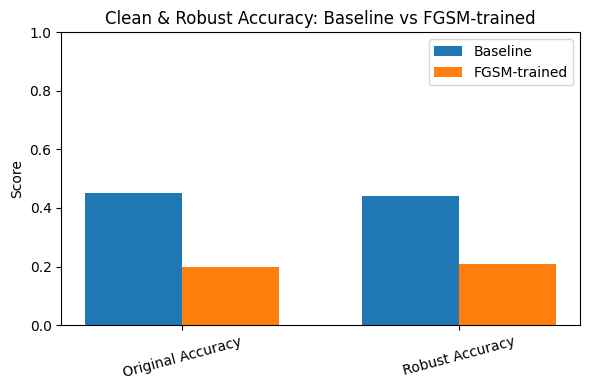

In [80]:
metrics_clean = ["Original Accuracy", "Robust Accuracy"]
baseline_values_clean = [baseline_results[m] for m in metrics_clean]
fgsm_values_clean     = [robust_results[m]   for m in metrics_clean]

x = np.arange(len(metrics_clean))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, baseline_values_clean, width, label="Baseline")
plt.bar(x + width/2, fgsm_values_clean,     width, label="FGSM-trained")

plt.xticks(x, metrics_clean, rotation=15)
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.title("Clean & Robust Accuracy: Baseline vs FGSM-trained")
plt.legend()
plt.tight_layout()
plt.show()

**6.2 Bar chart: ASR and robustness comparison**

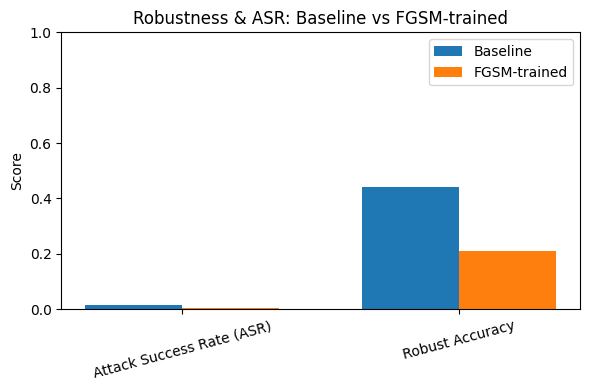

In [81]:
metrics_robust = ["Attack Success Rate (ASR)", "Robust Accuracy"]

baseline_values_robust = [baseline_results[m] for m in metrics_robust]
fgsm_values_robust     = [robust_results[m]   for m in metrics_robust]

x = np.arange(len(metrics_robust))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, baseline_values_robust, width, label="Baseline")
plt.bar(x + width/2, fgsm_values_robust,     width, label="FGSM-trained")

plt.xticks(x, metrics_robust, rotation=15)
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.title("Robustness & ASR: Baseline vs FGSM-trained")
plt.legend()
plt.tight_layout()
plt.show()

**6.3 Label distribution (train set)**

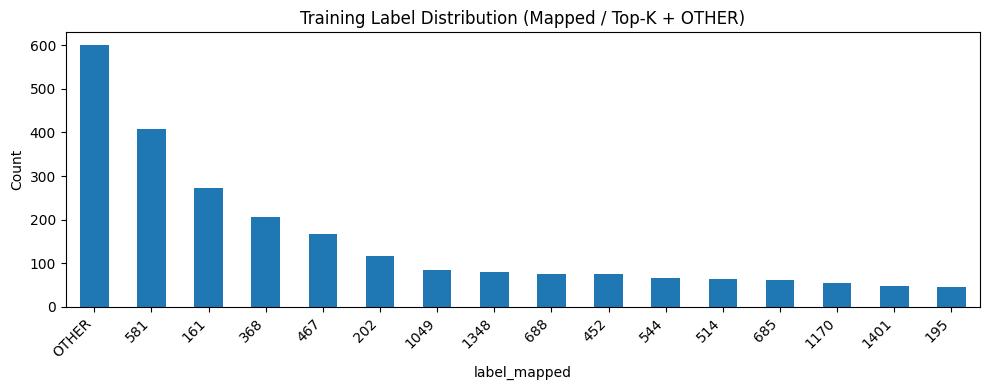

In [82]:
label_counts = final_train["label_mapped"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10,4))
label_counts.plot(kind="bar")
plt.ylabel("Count")
plt.title("Training Label Distribution (Mapped / Top-K + OTHER)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**6.4 Confusion Matrix Heatmap**

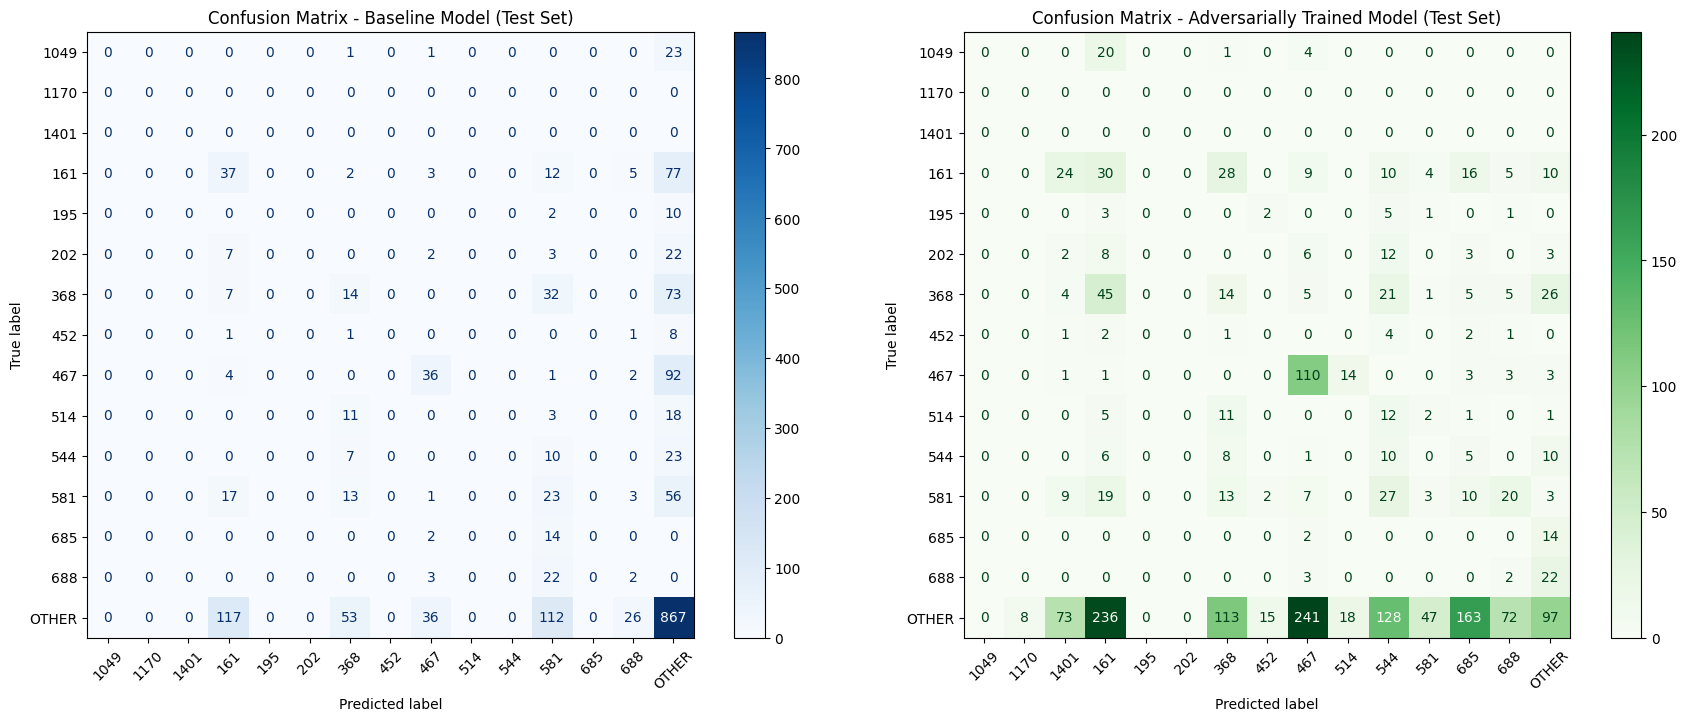

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import torch

# Get predictions and true labels for a given model and loader
def get_all_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# Build ordered label names from id2label dict for display
num_labels = len(id2label)

# Get predictions for BASELINE model on TEST set
y_true_baseline, y_pred_baseline = get_all_predictions(baseline_model, test_loader)

# Get predictions for ADVERSARIALLY TRAINED model on TEST set
y_true_adv, y_pred_adv = get_all_predictions(model, test_loader)

# Determine all unique labels actually present in the test data (true or predicted by either model)
all_test_y_values = np.concatenate((y_true_baseline, y_pred_baseline, y_true_adv, y_pred_adv))
unique_actual_encoded_labels = np.unique(all_test_y_values)
unique_actual_encoded_labels.sort() # Ensure consistent order

# Get the corresponding string names for these actual labels
actual_display_label_names = [id2label[label_id] for label_id in unique_actual_encoded_labels]

# Compute confusion matrices, ensuring labels argument matches the actual labels for display
cm_baseline = confusion_matrix(y_true_baseline, y_pred_baseline, labels=unique_actual_encoded_labels)
cm_adv = confusion_matrix(y_true_adv, y_pred_adv, labels=unique_actual_encoded_labels)

# Plot both confusion matrices side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Baseline Model Confusion Matrix
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=actual_display_label_names)
disp_baseline.plot(ax=axes[0], cmap="Blues", xticks_rotation=45, values_format='d')
axes[0].set_title("Confusion Matrix - Baseline Model (Test Set)")
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")

# Adversarially Trained Model Confusion Matrix
disp_adv = ConfusionMatrixDisplay(confusion_matrix=cm_adv, display_labels=actual_display_label_names)
disp_adv.plot(ax=axes[1], cmap="Greens", xticks_rotation=45, values_format='d')
axes[1].set_title("Confusion Matrix - Adversarially Trained Model (Test Set)")
axes[1].set_xlabel("Predicted label")
axes[1].set_ylabel("True label")

plt.tight_layout()
plt.show()

## **7. Conclusion & Future Work**



The baseline DistilBERT model for Cyber Threat Intelligence (CTI) classification achieved moderate original accuracy of 0.450 on clean data, demonstrating its ability to capture patterns in the imbalanced, multi-class dataset reduced to 16 labels including "OTHER." However, adversarial evaluation using simple text perturbations revealed vulnerabilities, with a robust accuracy of 0.440 and an attack success rate (ASR) of 0.015, indicating that minor changes can flip predictions for originally correct examples. Adversarial training with FGSM reduced the ASR by 66.67% to 0.005, showing improved resilience against attacks, but it also lowered original accuracy to 0.200 and robust accuracy to 0.210, highlighting the trade-off where robustness enhancements compromise clean performance in this noisy CTI domain.

This outcome underscores the challenges of applying straightforward adversarial methods to long-tail NLP tasks like CTI report classification, where class imbalance and domain-specific jargon amplify sensitivity to perturbations. While the baseline provides a practical starting point for threat categorization, the adversarially trained model prioritizes security over utility, suggesting that current techniques require refinement to balance both metrics effectively. Overall, these findings contribute to understanding model fragility in high-stakes applications, emphasizing the need for tailored defenses in cybersecurity NLP.

To address the observed robustness-accuracy trade-off, implement advanced adversarial training variants such as Projected Gradient Descent (PGD) with multiple steps or TRADES, which optimize for both clean and adversarial losses more effectively than single-step FGSM. Explore data-centric improvements, including targeted augmentation for rare CTI classes (e.g., MITRE ATT&CK-specific synthetic examples) and focal loss to mitigate imbalance without aggressive resampling. Additionally, integrate domain knowledge by fine-tuning on larger CTI corpora like those from MITRE or integrating graph-based features from threat knowledge bases to enhance generalization and evaluate against diverse attacks, such as black-box or semantic-preserving perturbations.